<div>
<img src="https://www.nebrija.com/images/logos/logotipo-universidad-nebrija.jpg" width="200">
</div>

**ALGORITMOS** -
Prof: Carmen Pellicer Lostao

# Optimizacion de Carteras o Portfolio


En este notebook vamos a utilizar el método de optimizacion de carteras de activos llamado MVO (Mean Variance Optimization) para calcular la composicion optima de una cartera. Resolveremos este ejercicio de forma clásica y cuantica, utilizando [algoritmos cuánticos variacionales](https://learning.quantum-computing.ibm.com/course/variational-algorithm-design) de optimizacion.

Dado un conjunto de $n$ activos $A_1, A_2,...,A_n$ podemos encontrar la composicion de una cartera optima expresada con un vector de pesos binario $x \in \{0, 1\}^n$, tal que maximice para el inversor los beneficios descontando riesgos (o que minimice la expresion opuesta).

## Método de optimizacion de carteras de activos llamado MVO (Mean Variance Optimization) 

El método MVO se basa en la hipotesis de que la distribucion de rentabilidades diarias de las acciones es normal y mide el beneficio como la media de esta distribucion y el riesgo como su varianza.

La rentabilidad y el riesgo de una cartera se modelan utilizando la *media* y la *varianza* de las fluctuaciones de los beneficios de los valores respectivamente.

Sea P una cartera de valores $A_1, A_2,...A_n$ con pesos binarios $x_1, x_2,...x_n$ y las rentabilidades $\mu_1, \mu_2, ...\mu_n$.

La **rentabilidad de la cartera $\mu$**  viene determinada por la suma de las medias ponderada de las rentabilidades diarias $\mu_i$de los valores que la componen:

$\mu= \mu^T x = \Sigma_{i=1}^{n} x_i * \mu_i$

El **riesgo de la cartera $\sigma$** es la desviacion estandar de la rentabilidad, que podemos calcular a partir de la matriz de covarianzas:

$\sigma = x^T \sigma x = \sqrt{\Sigma_{i=1}^{n} \Sigma_{j=1}^{n} x_i x_j \sigma_{i,j}}$

Por tanto, el método MVO propone que una cartera optima será aquella que cumpla la siguiente ecuacion:

$$\begin{aligned}
\min_{x \in \{0, 1\}^n}  q x^T \sigma x - \mu^T x\\
\text{sujeto a que: } 1^T x = B
\end{aligned}$$

donde se tiene:

- $x \in \{0, 1\}^n$ es un vector binario que indica si un valor esta o no en la cartera. Le llamamos el vector de decision, que indica que la acción $i$ esta en la cartera si $x[i] = 1$ y no esta si $x[i] = 0$,
- $\mu \in \mathbb{R}^n$ son las medias de las rentabilidades diarias de las acciones,
- $\sigma \in \mathbb{R}^{n \times n}$ son las covarianzas entre las rentabilidades de las acciones, lo que varia una si varia otra,
- $q > 0$ es un parametro con el que codificamos la afinidad al riesgo del inversor que diseña la cartera,
- y $B$ es el presupuesto o 'budget', i.e. limita el numero de acciones que podemos seleccionar sin superarlo.

La restriccion de que $1^T x = B$ se codifica como un termino de penalizacion $(1^T x - B)^2$ escalado por un parámetro y que se resta a la función objetivo o funcion de coste que vamos a minimizar. 

El problema resultante, es un problema QUBO (Quadratic Unconstrained Binary Optimization) y puede mapearse a una funcion de coste cuantica o Hamiltoniano cuyo estado minimo es la solucion optima.

Utilizaremos dos metodos de optimizacion cuántica para resolverlo:
- El Variational Quantum Eigensolver (VQE) 
- El Quantum Approximate Optimization Algorithm (QAOA)

Instalamos la librería de algoritmos e importamos las librerias necesarias

In [3]:
#!pip install qiskit-algorithms

In [4]:
#!pip install qiskit_finance

In [5]:
from qiskit import Aer, transpile
from qiskit.circuit.library import TwoLocal
from qiskit.utils import QuantumInstance
from qiskit.providers.fake_provider import FakeVigo
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_optimization.applications import OptimizationApplication
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit_finance.applications.optimization import PortfolioOptimization
from qiskit.utils import algorithm_globals
from qiskit.quantum_info import Statevector
from qiskit.tools.visualization import plot_histogram, plot_state_city

from qiskit.primitives import Estimator  #RUNTIME PRIMITIVE ESTIMATOR
from qiskit.circuit.library import TwoLocal

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [28]:
from qiskit.algorithms.minimum_eigensolvers import VQE, QAOA, SamplingVQE, NumPyMinimumEigensolver  # new import!!!
from qiskit_algorithms import NumPyMinimumEigensolver

from qiskit.algorithms.optimizers import SPSA, COBYLA, L_BFGS_B, SLSQP
from qiskit.primitives import Estimator, Sampler
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Options, Sampler, Estimator

### Seleccion de valores para la cartera

Utilizamos las librerias de Yahoo Finance para obtener un historico de cotizaciones de los valores que queramos utilizar en el ejercicio.

Algunos tickers de acciones que podriamos utilizar para el ejercicio podrían ser:

- valores o tickers Dow Jones:

['AAPL', 'AXP', 'BA', 'CAT', 'CSCO', 'CVX', 'DIS', 'GS', 'HD', 'IBM', 'INTC', 'JNJ', 'JPM', 'KO', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PFE', 'PG', 'TRV', 'UNH', 'UTX', 'V', 'VZ', 'WBA', 'WMT', 'XOM']

- valores o tickers España Mercado Continuo podrían ser: 

['FDR.MC','AMS.MC','PHM.MC','IBE.MC','REE.MC','ENG.MC','CABK.MC','GRF.MC','SAB.MC','ACS.MC','BBVA.MC','MTS.MC','ELE.MC','FER.MC','CLNX.MC','BKT.MC','TEF.MC','ACX.MC','ITX.MC','MAP.MC','AENA.MC','SAN.MC','REP.MC','SGRE.MC','NTGY.MC','MEL.MC','IAG.MC','MRL.MC','COL.MC','ANA.MC']


Instalamos las librerias

In [9]:
#!pip install yfinance

In [10]:
#!pip install yfinance
import yfinance as yfin

/opt/conda/lib/python3.10/site-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


In [12]:
#Podemos obtner datos de valores de las cotizaciones bursatiles de Yahoo que usamos para nuestro proyecto
tickers=['BBVA.MC', 'ACX.MC', 'NTGY.MC', 'REP.MC', 'CABK.MC']  #tomamos solo 5 valores, cada valor va a ser una variable binaria y requiere de 1 qubit
num_assets=len(tickers)

df_stocks = yfin.download(tickers=tickers, start='2023-01-01',end='2024-02-01')
df_stocks_aclose=df_stocks['Adj Close']
df_stocks_aclose.head()

[*********************100%%**********************]  5 of 5 completed


Ticker,ACX.MC,BBVA.MC,CABK.MC,NTGY.MC,REP.MC
Date,,,,,
2023-01-02,8.683646,5.394387,3.468153,23.265390,14.032221
2023-01-03,8.771287,5.475555,3.590712,23.019394,13.718135
2023-01-04,8.802325,5.691069,3.612230,23.407309,13.353242
2023-01-05,8.773111,5.741449,3.637491,23.000471,13.639615
2023-01-06,8.818758,5.793695,3.635619,23.483000,14.018363


Preparamos los datos comprobando que no hay nulos y si los hay completamos los valores con las cotizaciones pasadas mas cercanas. 

Para ello transformamos un `DataFrame` para que los valores de cotizaciones que no vienen informados, tomen la cotizacion del dia anterior.

Utilizamos los metodos `.fillna()` con valor `ffill` **fill forward** y luego `bfill ` **fill backwards** para completar los datos de cotizaciones sin introducir informacion adicional

In [13]:
no_info=df_stocks_aclose.isnull().sum().sum()

if  no_info != 0:
    print('Hay datos no informados')
    #ffill se debe de ejecutar primero para no meter datos del futuro (por si hacemos prediccion)
    #rellena hacia abajo, hacia el futuro - si el primer dato del pasado esta vacio no se podra llenar
    #se ejecuta entonces despues bfill para rellenar ese valor
    df_stocks_aclose=df_stocks_aclose.fillna(method='ffill').fillna(method='bfill').head(10) #el priner metodo que se ejecuta es el mas interno y a su resultado ejecuta el externo
        
else:
    print('Todos los datos estan informados')

Todos los datos estan informados


Creamos el vector de medias de beneficios y la matriz de covarianzas o riesgos

In [14]:
stockReturns=pd.DataFrame()
#computamos la rentabilidad diaria de cada accion
stockReturns= (df_stocks_aclose/df_stocks_aclose.shift() - 1)* 100
stockReturns.head()

Ticker,ACX.MC,BBVA.MC,CABK.MC,NTGY.MC,REP.MC
Date,,,,,
2023-01-02,NaN,NaN,NaN,NaN,NaN
2023-01-03,1.009262,1.504669,3.533857,-1.057349,-2.238320
2023-01-04,0.353862,3.935933,0.599268,1.685165,-2.659931
2023-01-05,-0.331889,0.885251,0.699297,-1.738079,2.144596
2023-01-06,0.520302,0.909981,-0.051440,2.097908,2.776823


In [15]:
#quitamos la primera fila
stockReturns.drop(labels=stockReturns.index[0], axis=0, inplace=True)
stockReturns

Ticker,ACX.MC,BBVA.MC,CABK.MC,NTGY.MC,REP.MC
Date,,,,,
2023-01-03,1.009262,1.504669,3.533857,-1.057349,-2.238320
2023-01-04,0.353862,3.935933,0.599268,1.685165,-2.659931
2023-01-05,-0.331889,0.885251,0.699297,-1.738079,2.144596
2023-01-06,0.520302,0.909981,-0.051440,2.097908,2.776823
2023-01-09,1.469979,1.078899,-1.338130,0.362618,-0.033723
...,...,...,...,...,...
2024-01-25,0.242769,-1.653291,-2.464434,-0.938966,0.380230
2024-01-26,-0.222001,0.024720,0.416776,-0.552920,1.893939
2024-01-29,0.930421,0.271877,0.181582,-0.397142,1.598514


In [16]:
mu=stockReturns.mean().to_numpy()
print('Vector de valores medios de los beneficios diarios de las acciones:',mu)

Vector de valores medios de los beneficios diarios de las acciones: [0.05193535 0.18738418 0.06069295 0.03127143 0.00302872]


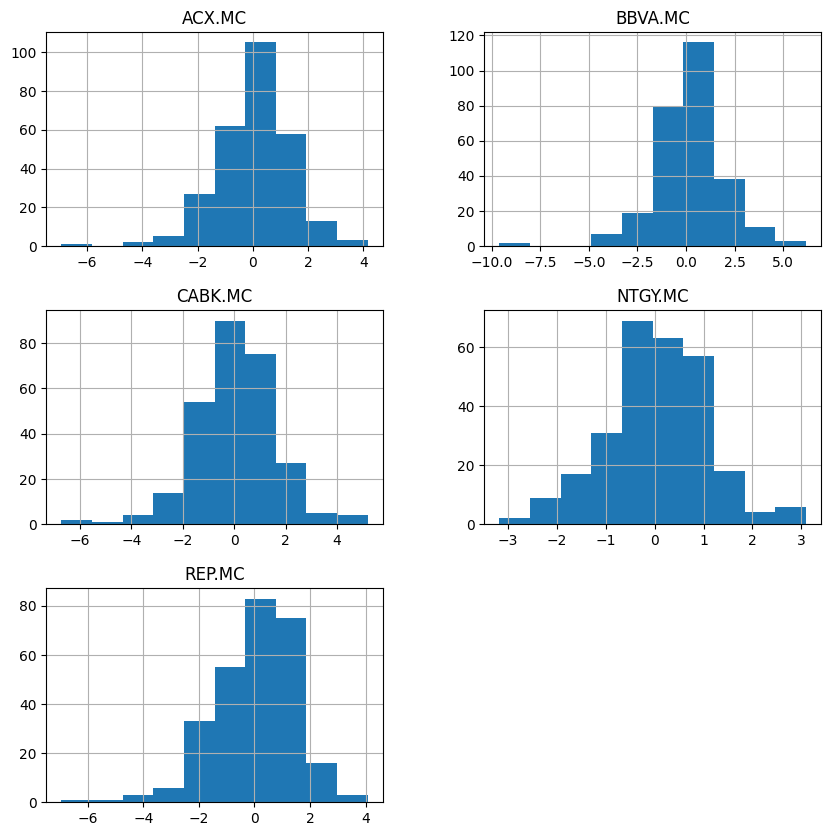

In [17]:
stockReturns.hist(figsize=(10,10));

In [18]:
#computamos la matriz de covarianzas de las rentabilidades 
sigma = stockReturns.cov().to_numpy()
print('Matriz de varianza covarianza de las acciones:\n', sigma)

Matriz de varianza covarianza de las acciones:
 [[1.76754117 1.11016025 0.86433804 0.29584046 0.57017372]
 [1.11016025 2.99585384 1.89789386 0.36590174 0.81690715]
 [0.86433804 1.89789386 2.63528097 0.16173299 0.71843156]
 [0.29584046 0.36590174 0.16173299 1.04601301 0.18525059]
 [0.57017372 0.81690715 0.71843156 0.18525059 2.1217654 ]]


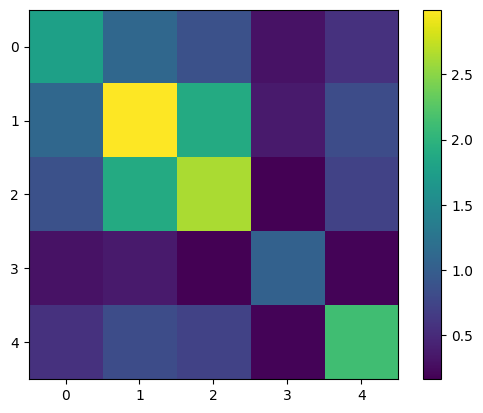

In [19]:
# plot sigma
plt.imshow(sigma, interpolation="nearest")
plt.colorbar()
plt.xticks(range(num_assets))
plt.yticks(range(num_assets))
plt.show()

## Definicion de la funcion de coste

A partir de la funcion objetivo de la optimizacion de la cartera, construimos una clase que la expresa como un problema tipo CUBO a partir de la cual podemos construir el circuito de coste para la optimizacion.

En Qiskit, exite una clase [`PortfolioOptimization`](https://qiskit-community.github.io/qiskit-finance/stubs/qiskit_finance.applications.PortfolioOptimization.html#) que nos permite escribir de una forma muy sencilla la funcion objetivo de la optimizacion de la cartera.

Esta clase contiene el metodo `to_quadratic_program()` que permite formular la ecuacion como un operador hamiltoniano y construir de forma mas o menos inmediata el circuito para computar el coste en los pasos de optimizacion.

#### EJERCICIO

Obten el objeto `QuadraticProgram` de nuestro problema de optimizacion MVO y su formulacion como objetos QUBO y operador Ising.

In [20]:
num_assets = len(tickers)
q = 0.5  # fijamos un factor de riesgo para el diseño de la cartera optima
budget = num_assets // 2  # fijamos un budget
penalty = num_assets  # fijamos un parametro de penalizacion para incorporar la restriccion en el problema QUBO

portfolio = PortfolioOptimization(
    expected_returns=mu, covariances=sigma, risk_factor=q, budget=budget
)

qp = portfolio.to_quadratic_program()
print(qp.prettyprint())

Problem name: Portfolio optimization

Minimize
  0.883770584725959*x_0^2 + 1.1101602488038245*x_0*x_1
  + 0.864338036953381*x_0*x_2 + 0.2958404601124945*x_0*x_3
  + 0.570173719646046*x_0*x_4 + 1.497926920459133*x_1^2
  + 1.8978938628278286*x_1*x_2 + 0.36590174132606357*x_1*x_3
  + 0.8169071543893927*x_1*x_4 + 1.3176404868075104*x_2^2
  + 0.16173298682034198*x_2*x_3 + 0.7184315593090641*x_2*x_4
  + 0.5230065068859084*x_3^2 + 0.18525058688691093*x_3*x_4
  + 1.0608826977062744*x_4^2 - 0.051935347657709297*x_0
  - 0.18738418262185755*x_1 - 0.060692950322453094*x_2 - 0.0312714304207979*x_3
  - 0.003028717843748249*x_4

Subject to
  Linear constraints (1)
    x_0 + x_1 + x_2 + x_3 + x_4 == 2  'c0'

  Binary variables (5)
    x_0 x_1 x_2 x_3 x_4



In [ ]:
#Para ver todos las propiedades y metodos de la clase PortfolioOptimization convertida a quadratic program
#dir(qp)

In [21]:
#converting to QUBO
qubo = QuadraticProgramToQubo().convert(qp)
print("QUBO:")
print(str(qubo)+'\n')

#converting QUBO task to Ising Hamiltonian for simulation on quantum computer
ising, offset = qubo.to_ising()
print("ISING Hamiltonian:")
print(ising)
print(offset)

QUBO:
minimize 14.487940767252658*x_0^2 + 28.318500613857225*x_0*x_1 + 28.07267840200678*x_0*x_2 + 27.504180825165893*x_0*x_3 + 27.778514084699445*x_0*x_4 + 15.102097102985832*x_1^2 + 29.106234227881227*x_1*x_2 + 27.57424210637946*x_1*x_3 + 28.025247519442793*x_1*x_4 + 14.92181066933421*x_2^2 + 27.370073351873742*x_2*x_3 + 27.926771924362463*x_2*x_4 + 14.127176689412607*x_3^2 + 27.39359095194031*x_3*x_4 + 14.665052880232974*x_4^2 - 54.46861607776451*x_0 - 54.60406491272865*x_1 - 54.47737368042925*x_2 - 54.44795216052759*x_3 - 54.419709447950545*x_4 + 54.4166807301068 (5 variables, 0 constraints, 'Portfolio optimization')

ISING Hamiltonian:
SparsePauliOp(['IIIIZ', 'IIIZI', 'IIZII', 'IZIII', 'ZIIII', 'IIIZZ', 'IIZIZ', 'IIZZI', 'IZIIZ', 'IZIZI', 'IZZII', 'ZIIIZ', 'ZIIZI', 'ZIZII', 'ZZIII'],
              coeffs=[-7.92813083+0.j, -8.50507221+0.j, -8.34115797+0.j, -7.30013407+0.j,
 -7.90370284+0.j,  7.07962515+0.j,  7.0181696 +0.j,  7.27655856+0.j,
  6.87604521+0.j,  6.89356053+0.j,  6.842

## Optimizacion clásica

Vamos a resolver el problema de forma clásica para poder contrartar los resultados con la forma cuántica y ver que se optiene la misma solucion.

Podemos hacer una optimizacion clásica utilizando las librerias numericas de python `numpy`. Esto esta ya programado en Qiskit gracias a la clase `NumPyMinimumEigensolver` a la que podemos pasar una funcion de coste en forma de programa cuadrático y nos devuelve la solucion optima con los datos en un diccionario.

Esta clase, toma el operador hamiltoniano de la funcion de coste y calcula el valor propio minimo de forma numerica clasica.

#### EJERCICIO

Utiliza el método `compute_minimum_eigenvalue` de la clase [`NumpyMinimumEigensolver`](https://qiskit-community.github.io/qiskit-algorithms/stubs/qiskit_algorithms.NumPyEigensolver.html) para resolver la optimizacion del operador H (el problema formulado como Ising el vector propio encontrando el vector propio de minima energia.

Convierte en un objeto tipo `Statevector` el resultado e imprime el diccionario de probabilidades que tiene con el metodo `probabilities_dict()`

In [22]:
#solve the optimization problem
npme = NumPyMinimumEigensolver()
result = npme.compute_minimum_eigenvalue(ising)
print('result:\n', result)
#print('\nsolution:\n', maxcut.interpret(result))
#maxcut.draw(result, pos=pos)

#create Statevector with the eigenvector or eigenstate and print the probabilities dictionary
vector=result.eigenstate
probabilities = Statevector(vector).probabilities_dict()
print(probabilities)

result:
 {   'aux_operators_evaluated': None,
    'eigenstate': Statevector([0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2)),
    'eigenvalue': (-23.00795937327214+0j)}
{'01001': 1.0}


## Optimizacion cuántica utilizando el algoritmo VQE

Utilizaremos el algoritmo Variational Quantum Eigensolver (VQE) para resolver el problema de optimizacion de la cartera.

Para ello necesitamos unos pasos previos:

1) construir un circuito variacional o `ansatz` con unos parametros. Utilizaremos la clase [TwoLocal](https://qiskit.org/documentation/stubs/qiskit.circuit.library.TwoLocal.html) de Qiskit que construye un circuito variacional a conveniencia, con diferentes parametros y configuraciones.

2) Seleccionar una funcion de optimizacion clasica que nos guia para encontrar el minimo.

3) Definimos un backend de ejecucion, un simulador

Después usaremos la clase `VQE` de Qiskit para definir el optimizador y le pasaremos el ansatz, la funcion de optimizacion y el backend de ejecucion.

Utilizamos la clase `MinimumEigenOptimizer` para lanzar el proceso de optimizacion y le pasaremos la funcion de coste cuadratica del metodo MVO para que evalue los costes y encuentre el minimo

#### EJERCICIO

Utiliza el método `compute_minimum_eigenvalue()` de la clase [`SamplingVQE`](https://qiskit-community.github.io/qiskit-algorithms/stubs/qiskit_algorithms.SamplingVQE.html#qiskit_algorithms.SamplingVQE) para resolver la optimizacion del operador H (el problema formulado como Ising), encontrando el vector propio de minima energia.

Investiga la clase de resultado que devuelve este algoritmo [SamplingVQEResult](https://qiskit-community.github.io/qiskit-algorithms/stubs/qiskit_algorithms.SamplingVQEResult.html) y utilizando el metodo `best_measuretments()` imprime el resultado binario y dibuja el grafo obteindo de la minimizacion.

In [26]:
n=num_assets
ansatz = TwoLocal(n, 'ry', 'cz')
opt = SPSA(maxiter=50)
 
# shot-based simulation
sampler = Sampler(options={"shots": 2048})
vqe = SamplingVQE(sampler, ansatz, opt, aggregation=0.2)

result = vqe.compute_minimum_eigenvalue(ising)
print(result)
nd=np.array([int(i) for i in result.best_measurement['bitstring']])
print(nd)

SamplingMinimumEigensolverResult:
	Eigenvalue: -22.903802854247264
	Best measurement
: {'state': 9, 'bitstring': '01001', 'value': (-23.00795937327214+0j), 'probability': 0.18408203125}

[0 1 0 0 1]


#### EJERCICIO

Muestra el circuito variacional optimo que ha encontrado el optimizador, ejecuta el circuito y muestra el histograma de salida, para ver el estado optimo que hemos encontrado

## Optimizacion cuántica utilizando el algoritmo QAOA

Utilizaremos el algoritmo Qantum Approximate Optimization Algorithm (QAOA) para resolver el problema de optimizacion de la cartera. Este es otro algoritmo que utiliza un circuito variacional definido internamente y no necesitamos crearlo explicitamente.

Para ejecutarlo necesitamos los pasos previos anteriores:

1) Seleccionar una funcion de optimizacion clasica que nos guia para encontrar el minimo.

2) Definimos un backend de ejecucion, un simulador

Después usaremos la clase `QAOA` de Qiskit para definir el optimizador y le pasaremos el ansatz, la funcion de optimizacion y el backend de ejecucion. Tambien tendremos que especificar el numero de repeticiones que ejecutaremos en el algoritmo `QAOA`.

Utilizamos la clase `MinimumEigenOptimizer` para lanzar el proceso de optimizacion y le pasaremos la funcion de coste cuadratica del metodo MVO para que evalue los costes y encuentre el minimo

#### EJERCICIO

Utiliza el método `compute_minimum_eigenvalue()` de la clase [`QAOA`](https://qiskit-community.github.io/qiskit-algorithms/stubs/qiskit_algorithms.QAOA.html) para resolver la optimizacion del operador H (el problema formulado como Ising), encontrando el vector propio de minima energia.

La clase `QAOA` se contruye a partir de la clase `SamplingVQE`por lo que devuelve la misma clase de resultados, [SamplingVQEResult](https://qiskit-community.github.io/qiskit-algorithms/stubs/qiskit_algorithms.SamplingVQEResult.html). Utiliza el metodo `best_measuretments()` imprime el resultado binario y dibuja el grafo obteindo de la minimizacion.

In [24]:
# exact statevector simulation
sampler = Sampler()
 
optimizer = COBYLA()
qaoa = QAOA(sampler, optimizer, reps=2)
 
# diagonal operator
result = qaoa.compute_minimum_eigenvalue(ising)
 
print(result)
nd=np.array([int(i) for i in result.best_measurement['bitstring']])
print(nd)

SamplingMinimumEigensolverResult:
	Eigenvalue: -7.9444988993321815
	Best measurement
: {'state': 9, 'bitstring': '01001', 'value': (-23.00795937327214+0j), 'probability': 0.1157737438613033}

[0 1 0 0 1]


#### EJERCICIO

Muestra el circuito variacional optimo que ha encontrado el optimizador, ejecuta el circuito y muestra el histograma de salida, para ver el estado optimo que hemos encontrado

In [ ]:
#podemos ver el circuito optimo
display(result.optimal_circuit.decompose().draw(fold=-1))

#podemos ejecutarlo, uno de esos estados que ha muestreado el circuito variacional ha dado minima energia
circuit = result.optimal_circuit.bind_parameters(result.optimal_parameters)

# Hacemos un transpile del circuito para el simulador
simulator = Aer.get_backend('aer_simulator')
circ = transpile(circuit, simulator)  #opcional

# lo corremos y obtenemos los resultados
result = simulator.run(circ,shots=2000).result()
counts = result.get_counts(circ)
for k,v in counts.items():
    print(k,v)
plot_histogram(counts, title='Optimal Maxcut counts')